# **Physical Activity Prediciton**

### Team Members:

 - **Abed El Kader EL SHAAR**
 - **Ahmad AL MASRI**
 - **Ahmad KHALIFE**
 - **Hadi JABER**
 - **Karen KHOURY**
 - **Sara GHAMLOUSH**

This challenge was done as a project for the Master 2 Data Science (2022/2023), DATACAMP course:
<br><br>


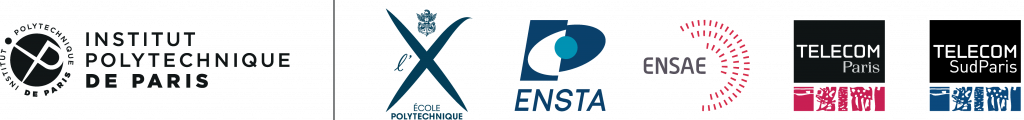

## Introduction

Physical activity plays an important role in controlling obesity and maintaining a healthy living. It becomes increasingly important during a pandemic due to restrictions on outdoor activities.
Tracking physical activities using miniature wearable sensors and state-of-the-art machine learning
techniques can encourage healthy living and control obesity. 

This project focuses on introducing novel techniques to identify and log physical activities using machine learning techniques and wearable sensors. Physical activities performed in daily life are often unstructured and unplanned, and one
activity or set of activities (sitting, standing) might be more frequent than others (walking, stairs
up, stairs down).

The outcome of this project should be to be able to classify activities based on the different sensors readings, and thus gain insights on what muscles are used to do different activities and what activities might be easier or more common than others.

## Description of the data

The dataset used is [PAMAP2](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring)(Physical Activity Monitoring for Aging People). It was created in autumn 2011 for the purpose of monitoring physical activity in older individuals. It includes data from 9 subjects, wearing 3 IMUs and a HR-monitor, and performing 18 different activities. Over 10 hours of data were collected altogether, from which nearly 8 hours were labeled as one of the 18 activities.

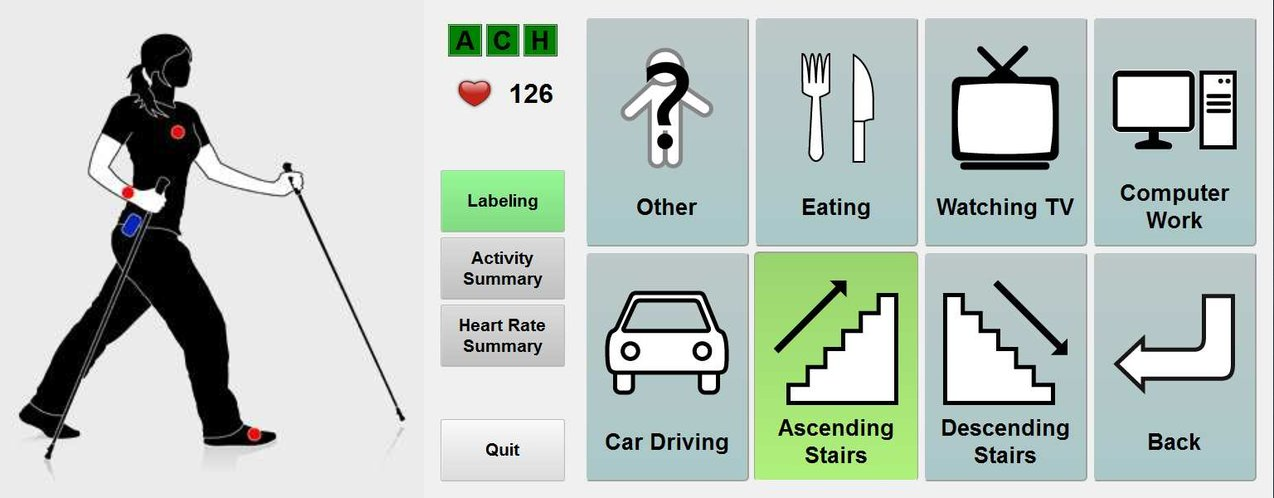

### Hardware Set-up
The PAMAP2 dataset was collected using three wireless Colibri **inertial measurement units** (IMUs) from Trivisio. Each IMU contains two 3-axis MEMS accelerometers (range: ±16 g / ±6 g, resolution: 13-bit), a 3-axis MEMS gyroscope (range: ±1500◦/s, resolution: 13-bit), and a 3-axis magneto-resistive magnetic sensor (range: ±400 μT, resolution: 12-bit), all sampled at 100Hz. To obtain heart rate information, a BM-CS5SR HR-monitor from BM innovations GmbH was used, providing heart rate values with approximately 9Hz. The sensors were placed onto 3 different body positions. A chest sensor fixation includes one IMU and the heart rate chest strap. The second IMU is attached over the wrist on the dominant arm, and the third IMU on the dominant side’s ankle, both are fixed with sensor straps. A Viliv S5 UMPC was used as data collection unit.

A graphical user interface (GUI) was developed for labeling the activities being performed during data collection. The labeling tool was installed on the UMPC and provided options to label both basic and a wide range of everyday, household, and sport activities. The GUI also displayed symbols indicating the continuous operation of the IMUs and HR-monitor. The beginning and end of each activity were marked with timestamps using the labeling tool on the UMPC, allowing for synchronization with the raw sensory data. The data collection and labeling were implemented in separate threads in an application running on the collection unit.

### Subjects
In total nine subjects participated in the data collection, eight males and one female. The subjects weremainly employees or students at a research center, aged 27.22 ±3.31 years, and having a BMI of 25.11 ±2.62 kgm−2. One subject was left-handed, all the others were right-handed.

### Data Collection Protocol
One of the goals of physical activity monitoring is to estimate the intensity of performed activities. A HR-monitor is included in the hardware setup of the data collection, this way heart rate related features can be considered for this task during
data processing. Therefore, a short break is inserted in the data collection protocol after most of the activities. The duration of the breaks were chosen so that the heart rate of the subjects was allowed to return to the “normal” range after performing an activity. The goal was to ensure that the measured heart rate was unaffected by the previous activities. For this purpose, a 1-minute break was sufficient after most of the activities, except for the most exhausting ones (ascending stairs, running and playing soccer), after which activities a 2-minutes break was inserted. Most of the activities from the protocol were performed over approximately 3-minutes, except ascending/descending stairs (due to limitations of the building where the indoor activities were carried out) and rope jumping (to avoid exhaustion of the subjects).

## **Requirements for running the notebook**

To properly run the notebook, the following Python modules must be imported :

In [1]:
!pip install ramp-workflow

Defaulting to user installation because normal site-packages is not writeable


## Getting the data

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To get the data, simply invoke download_data.py as follow:

In [3]:
%run download_data.py

Extracting data...
Done


### Preparations done on the data

We have prepared our data in such a way that:
- The public training data consists of activities performed by subjects : 1, 2, 3, 4, 9
- The public testing data consists of activities performed by subjects : 6, 7
- The private data (hidden from the user) consists of activites performed by subject : 8

The evaluation metrics will be based on the negative log loss and the accuracy, we will measure these metrics using a LeaveOneGroupOut crossvalidation where at each fold we train on all subjects except for one.

### Inspecting the data

In [39]:
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data()
data_test, labels_test = get_test_data()

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197898 entries, 0 to 1197897
Data columns (total 54 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp          1197898 non-null  float64
 1   heartrate          1197898 non-null  float64
 2   handTemperature    1197898 non-null  float64
 3   handAcc16_1        1197898 non-null  float64
 4   handAcc16_2        1197898 non-null  float64
 5   handAcc16_3        1197898 non-null  float64
 6   handAcc6_1         1197898 non-null  float64
 7   handAcc6_2         1197898 non-null  float64
 8   handAcc6_3         1197898 non-null  float64
 9   handGyro1          1197898 non-null  float64
 10  handGyro2          1197898 non-null  float64
 11  handGyro3          1197898 non-null  float64
 12  handMagne1         1197898 non-null  float64
 13  handMagne2         1197898 non-null  float64
 14  handMagne3         1197898 non-null  float64
 15  handOrientation1   1197898 non-n

An IMU sensor was used to capture measurements related to the hand, chest and ankle.
For instance : 

- 1 : hand temperature (°C)
- 2-4 : hand 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
- 5-7 : hand 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 : hand 3D-gyroscope data (rad/s)
- 11-13 : hand 3D-magnetometer data (μT)
- 14-17 : hand orientation (invalid in this data collection)

In [11]:
data_train

,timestamp,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,166.11,100.0,31.000,-1.43105,5.40588,7.77487,-1.25869,5.42474,7.86577,-0.149700,...,-0.059007,0.107266,-43.6954,1.163090,57.379200,0.692245,-0.023364,0.721249,-0.007120,3
1,166.12,100.0,31.000,-1.57471,5.14382,8.04301,-1.42397,5.42599,7.92634,-0.153853,...,-0.067527,0.091327,-42.7963,0.696723,56.871700,0.691951,-0.022061,0.721579,-0.006368,3
2,166.13,100.0,31.000,-1.88156,4.50119,8.04059,-1.62143,5.06513,8.10854,-0.093763,...,-0.060329,0.094986,-42.8046,1.573020,57.376200,0.691679,-0.020295,0.721899,-0.005466,3
3,166.14,100.0,31.000,-1.84377,4.50090,8.04115,-1.62562,4.58187,8.09451,-0.082387,...,-0.102539,0.114357,-42.9115,0.921397,56.875100,0.691223,-0.018539,0.722390,-0.004570,3
4,166.15,100.0,31.000,-1.78781,5.18687,8.42455,-1.73035,4.59780,8.17008,-0.033998,...,-0.078463,0.089137,-42.7882,0.467699,57.488100,0.690850,-0.016559,0.722801,-0.003180,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197893,95.06,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,-0.289166,...,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,9
1197894,95.07,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,-0.275411,...,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,9
1197895,95.08,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,-0.289885,...,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,9
1197896,95.09,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,-0.234417,...,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,9


In [12]:
labels_train

array([ 1,  1,  1, ..., 24, 24, 24])

## Exploratory Data Analysis

### Data Statistics

In [13]:
data_train['heartrate'].describe()

count    1.197898e+06
mean     1.100257e+02
std      2.573248e+01
min      5.700000e+01
25%      8.900000e+01
50%      1.090000e+02
75%      1.260000e+02
max      1.830000e+02
Name: heartrate, dtype: float64

We can see a big difference between the min and max value of Heartrates, those may be outliers, or just the idea that Heartrate differs vastly between different activities .

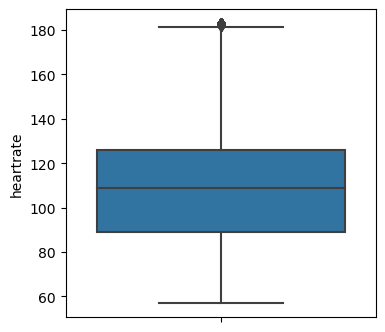

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(y=data_train["heartrate"]);

Looking at the box plot, we can see that values bigger than 180 are classified as outliers. <br>
To find the most cumbersome activities we can plot a bar chart showing the mean values of heart rates for each activity:

<AxesSubplot:xlabel='activityID'>

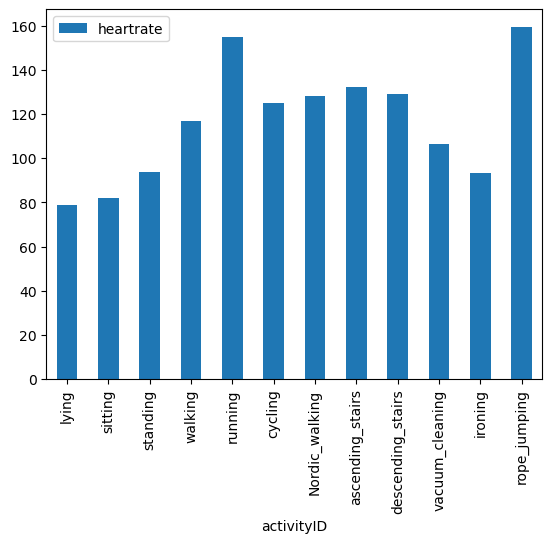

In [15]:
concat_data = pd.concat([data_train,pd.DataFrame(labels_train, columns =['activityID'])],axis = 1)
df_grp = concat_data.groupby('activityID').agg({'heartrate': 'mean'})
df_grp.index = df_grp.index.map(activityIDdict)
df_grp.plot(kind='bar')

The bar chart shows that Rope Jumping and Running are the most cumbersome activities out of all the activities, and those might be the reason some heartrates are above 180 (and thus not outliers).

### Checking if the data is balanced

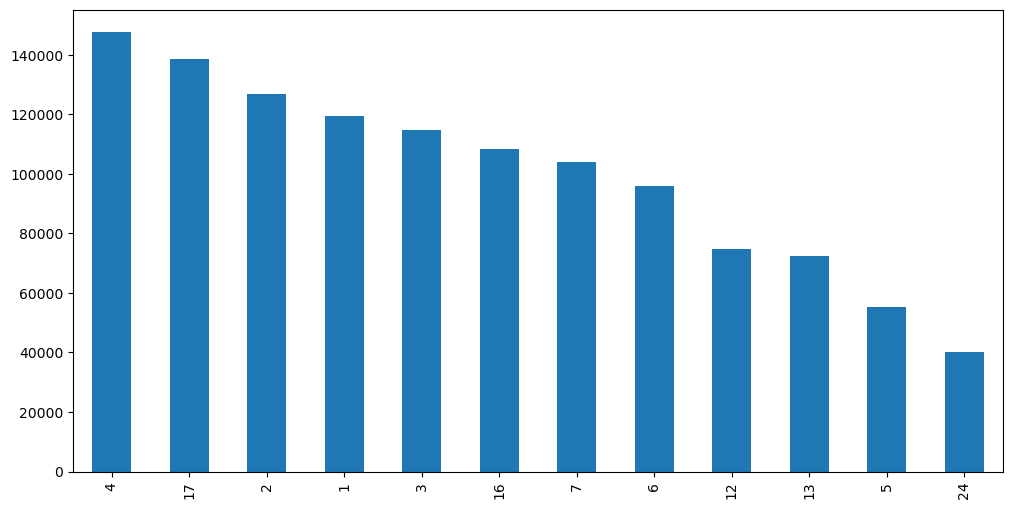

In [16]:
concat_data['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

As the above plot shows, classes are mostly balanced, with activity 24 being the least exercised.<br>

### What are the activities done by each subject_id?

In [17]:
# Group the data by subject_id and get the unique activityIDs for each group
activities_by_subject = concat_data.groupby('subject_id')['activityID'].unique()

# Print out the activities for each subject
for subject_id, activities in activities_by_subject.items():
    print(f"Subject {subject_id} performed the following activities: {activities}")

Subject 1 performed the following activities: [ 1  2  3 17 16 12 13  4  7  6  5 24]
Subject 2 performed the following activities: [ 1  2  3 17 16 12 13  4  7  6  5 24]
Subject 3 performed the following activities: [ 1  2  3 17 16 13 12  4]
Subject 4 performed the following activities: [ 1  2  3 17 16 12 13  4  7  6  5]
Subject 5 performed the following activities: [ 1  2  3 17 16 12 13  4  7  6  5 24]
Subject 9 performed the following activities: [24]


### Plotting different measurements

In [18]:
def plot_temperatures_and_heartrate(start_time, end_time, data, activity_id, subject_id):
    # Filter data by timestamp range and activity id
    filtered_data = data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time) & (data['activityID'] == activity_id) & (data['subject_id'] == subject_id)]

    # Create figure and axes
    fig, axs = plt.subplots(5, sharex=True, figsize=(10, 10))

    # Plot heartrate in the first subplot
    axs[0].plot(filtered_data['timestamp'], filtered_data['heartrate'])
    axs[0].set_ylabel('Heartrate')

    # Plot temperature data in the second subplot
    axs[1].plot(filtered_data['timestamp'], filtered_data['handTemperature'], label='Hand')
    axs[1].plot(filtered_data['timestamp'], filtered_data['chestTemperature'], label='Chest')
    axs[1].plot(filtered_data['timestamp'], filtered_data['ankleTemperature'], label='Ankle')
    axs[1].set_ylabel('Temperature')
    axs[1].legend()

    # Plot hand acceleration data in the second subplot
    axs[2].plot(filtered_data['timestamp'], filtered_data['handAcc16_1'], label='HandAcc 1')
    axs[2].plot(filtered_data['timestamp'], filtered_data['handAcc16_2'], label='HandAcc 2')
    axs[2].plot(filtered_data['timestamp'], filtered_data['handAcc16_3'], label='HandAcc 3')
    axs[2].set_ylabel('Hand Accelerometer 16g')
    axs[2].legend()
    
    # Plot Chest Gyroscope data in the second subplot
    axs[3].plot(filtered_data['timestamp'], filtered_data['chestGyro1'], label='ChestGyro 1')
    axs[3].plot(filtered_data['timestamp'], filtered_data['chestGyro2'], label='ChestGyro 2')
    axs[3].plot(filtered_data['timestamp'], filtered_data['chestGyro3'], label='ChestGyro 3')
    axs[3].set_ylabel('Chest Gyroscope 16g')
    axs[3].legend()

    # Plot Magnetometer measures for ankle data in the second subplot
    axs[4].plot(filtered_data['timestamp'], filtered_data['ankleMagne1'], label='AnkleMagne 1')
    axs[4].plot(filtered_data['timestamp'], filtered_data['ankleMagne2'], label='AnkleMagne 2')
    axs[4].plot(filtered_data['timestamp'], filtered_data['ankleMagne3'], label='AnkleMagne 3')
    axs[4].set_ylabel('Ankle Magnetometer')
    axs[4].legend()
    
    # Add vertical lines for activity start and end
    activity_start = filtered_data['timestamp'].iloc[0]
    activity_end = filtered_data['timestamp'].iloc[-1]
    for ax in axs:
        ax.axvline(activity_start, color='r', linestyle='--')
        ax.axvline(activity_end, color='r', linestyle='--')

    # Set plot title
    plt.suptitle(f'Activity {activity_id} from {start_time} to {end_time} for Subject {subject_id}')

    plt.show()


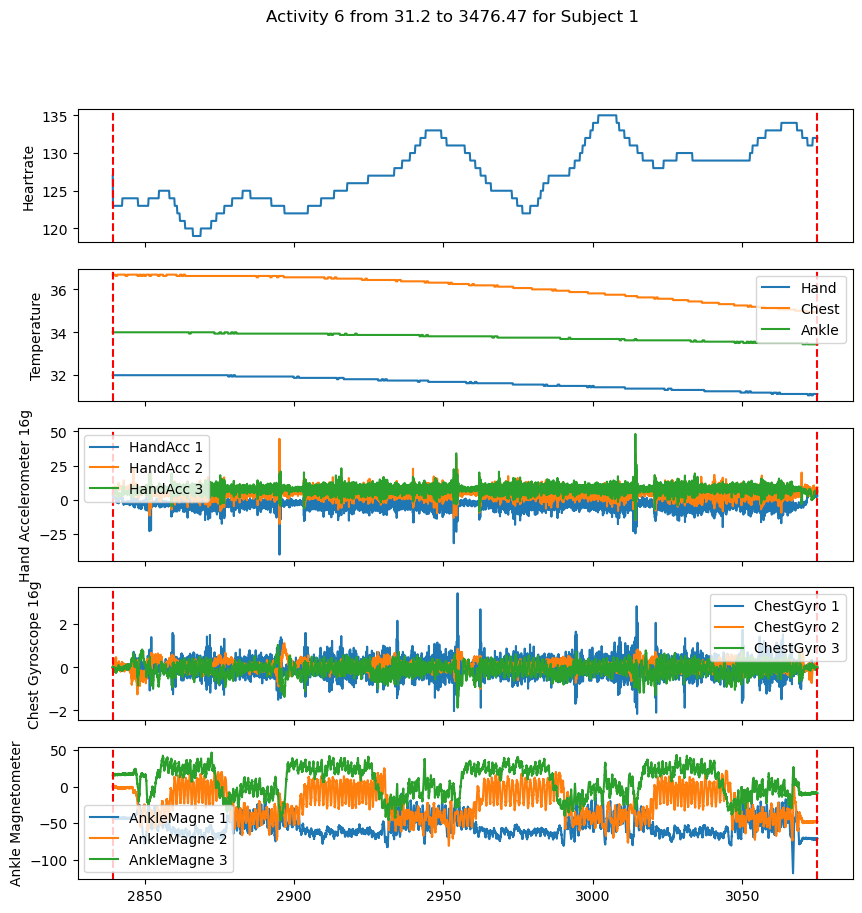

In [19]:
start_time = 31.2
end_time = 3476.47
activity_id = 6
subject_id= 1

plot_temperatures_and_heartrate(start_time, end_time, concat_data, activity_id,subject_id)

In [20]:
def plot_hr_distribution(dataframe, subject_id):
    subset = dataframe[dataframe.subject_id == subject_id]
    activity_ids = subset.activityID.unique()
    fig, ax = plt.subplots(figsize=(10, 5))
    for activity_id in activity_ids:
        activity_subset = subset[subset.activityID == activity_id]
        ax.plot(activity_subset.timestamp, activity_subset.heartrate, label=f"Activity {activity_id}")
        start_times = activity_subset[activity_subset.activityID.diff() != 0].timestamp.tolist()
        for start_time in start_times:
            ax.axvline(x=start_time, linestyle='--', color='gray')
        end_times = activity_subset[activity_subset.activityID.diff(periods=-1) != 0].timestamp.tolist()
        for end_time in end_times:
            ax.axvline(x=end_time, linestyle='--', color='gray')
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Heart Rate")
    ax.set_title(f"Heart Rate Distribution for Subject {subject_id}")
    ax.legend()
    plt.show()

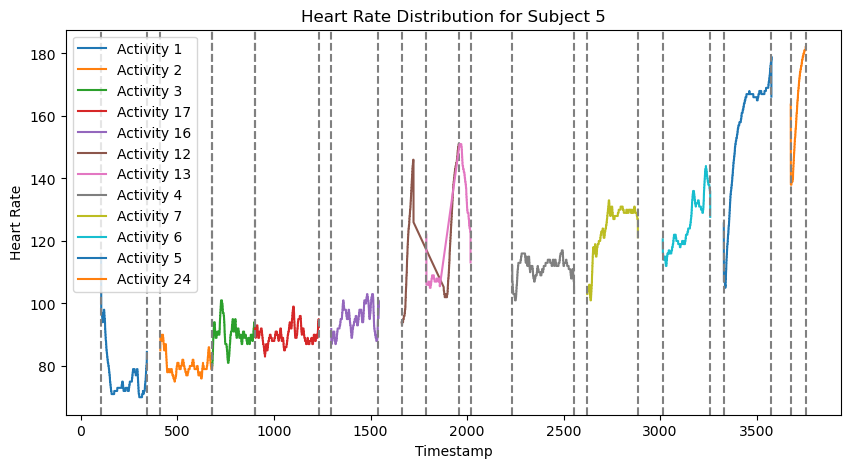

In [21]:
subject_id=5
plot_hr_distribution(concat_data, subject_id)

The goal of inserting breaks was to ensure that the measured heart rate was unaffected by the previous activities. For this purpose, a 1-minute break was sufficient after most of the activities, except for the most exhausting ones (ascending stairs, running and playing soccer), after which activities a 2-minutes break was inserted. However, since in everyday situations the influence of activities on the next performed ones can not be excluded, this influence was also simulated in the data collection protocol: descending stairs(Activity 13) was performed directly after ascending stairs(Activity 12) and normal walking directly after running

In [22]:
# check if the statistics of a certain activity for a certain subject_id are similar.
def feature_stats_by_activity_and_subject(df, feature, statistic):
    """
    Calculates the mean, median, or standard deviation of a feature in a dataframe
    for each activity id and subject id combination.
    
    Args:
        df (pd.DataFrame): the input dataframe
        feature (str): the name of the feature column
        statistic (str): the desired statistic to calculate (mean, median, or std)
    
    Returns:
        pd.DataFrame: a new dataframe with the calculated values for each
            activity ID and subject ID combination
    """
    
    # Group the dataframe by activity ID and subject ID
    grouped = df.groupby(['activityID', 'subject_id'])
    
    # Calculate the desired statistic for the specified feature column
    if statistic == 'mean':
        result = grouped[feature].mean()
    elif statistic == 'median':
        result = grouped[feature].median()
    elif statistic == 'std':
        result = grouped[feature].std()
    else:
        raise ValueError('Invalid statistic: {}. Must be mean, median, or std.'.format(statistic))
    
    # Convert the result to a dataframe and reset the index
    result = pd.DataFrame(result).reset_index()
    
    return result

In [23]:
heart_rate_means = feature_stats_by_activity_and_subject(concat_data, 'heartrate', 'mean')
heart_rate_means.head(9)

,activityID,subject_id,heartrate
0,1,1,87.529941
1,1,2,79.562875
2,1,3,74.036826
3,1,4,74.626893
4,1,5,76.521981
5,2,1,91.183816
6,2,2,81.020374
7,2,3,75.994931
8,2,4,83.210184


### Baseline Model

The following is an example estimator which can be found in submissions\starting_kit

In [25]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

def compute_moving_average(X_df, feature, time_window, center=False):
    """
    For a given dataframe, compute the moving average over
    a defined period of time (time_window) of a defined feature
 
    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    X_cop = X_df.copy()
    name = "_".join([feature, str(time_window), "avg"])
    X_cop[name] = X_cop.groupby('subject_id')[feature].rolling(time_window).mean().reset_index(0,drop=True)
    X_cop[name] = X_cop[name].ffill().bfill()
    X_cop[name] = X_cop[name].astype(X_cop[feature].dtype)

    return X_cop

def compute_lagged_features(X_df, feature, lag_value):
    name  = feature + "_lag_" + str(lag_value)
    X_cop = X_df.copy()
    X_cop[name] = X_cop[feature].shift(lag_value)
    X_cop[name] = X_cop[name].ffill().bfill()
    return X_cop




class FeatureExtractor(BaseEstimator):

    def fit(self, X, y):
        return self

    def transform(self, X):
        X = compute_moving_average(X,'heartrate', 3)
        return X



def get_estimator():

    feature_extractor = FeatureExtractor()

    classifier1 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    pipe = make_pipeline(feature_extractor, classifier1)
    return pipe

In [26]:
from problem import get_test_data
from sklearn.metrics import accuracy_score, log_loss
data_test, labels_Test = get_test_data()

### Evaluation

We will now evaluate the model using log loss and accuracy

In [27]:
model = get_estimator()
model.fit(data_train,labels_train)
y_pred = model.predict(data_test)
y_pred_proba = model.predict_proba(data_test)
print("The log loss = {}".format(log_loss(labels_test,y_pred_proba)))
print("The accuracy = {}".format(accuracy_score(labels_test,y_pred)))

/home/infres/aalmasri-21/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The log loss = 0.6987813604582259
The accuracy = 0.8255748935535712


Vizualizing our predictions :

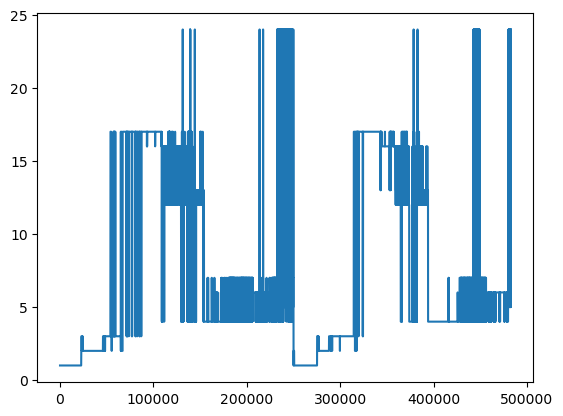

In [45]:
plt.plot(y_pred)

The plot shows that our predictions can go back and forth between activities, and since our data is a time series data sampled at 100 hz (0.01 seconds), this is not natural.
We will take a quick example to illustrate this : let us say we have 2 activities running and swimming, it is not possible for a subject to go from running to swimming and back to running in a time frame of 0.03 seconds.

This is why smoothing the data might be important.

To illustrate this, we will use exponential smoothing on our output:

In [63]:
labels = [ 1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24]
class_dict = dict(enumerate(labels))
s_ypred_proba = pd.DataFrame(y_pred_proba).ewm(com=1000).mean().to_numpy()
s_ypred = (s_ypred_proba.argmax(axis=1))
s_ypred = [class_dict[i] for i in s_ypred]
score = accuracy_score(labels_test,s_ypred)
score

0.8636325982869166

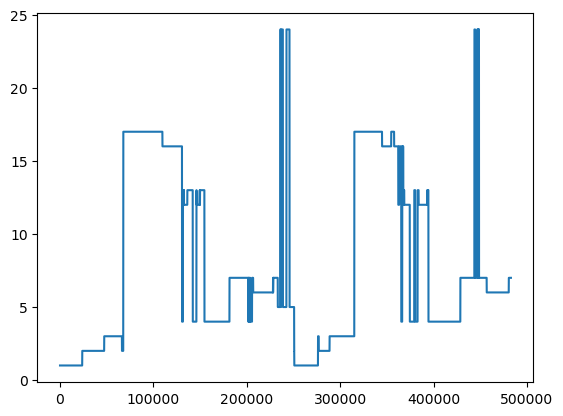

In [65]:
plt.plot(s_ypred)

As we can see, we can improve the accuracy with smoothing.
Note that the smoothing used above combines the probabilities of all subjects which is not ideal, a better smoothing strategy would be to smooth each subject's output independently of other subjects.

### Submission

Each ramp submisison should be inside the folder submissions which should contain your estimator.py file, an estimator example has been put inside the folder, note that the estimator should return a pipeline, you can change the feature extraction functions along with the model to get a better score.

### Ramp test example

To evaluate how good you model is before submitting, you can run : 

ramp-test --submission starting_kit (add --quick-test to only use a small subset of the data)

This will give you an overview of your score.

Once you are satisfied with your score, head to the official ramp website dedicated to the challenge and submit your model.

In [ ]:
!ramp-test --quick-test --submission starting_kit